In [1]:
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
     

import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [4]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

In [5]:
class SGD:
    def __init__(self, params ,lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i += 1

    def opt_step(self,p): p -= p.grad * self.lr
    def reg_step(self,p): 
        if self.wd != 0: p *= 1 - self.lr * self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, 0.4, cbs=cbs, opt_func=SGD)

In [ ]:
learn.fit(3)

In [ ]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom = mom

    def opt_step(self,p): 
        if not hasattr(p,'grad_avg'): p.grad_avg = torch.zeros_like(p)
        p.grad_avg = p.grad_avg  * self.mom + p.grad * (1-self.mom)
        p -=  p.grad_avg * self.lr

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, 0.4, cbs=cbs, opt_func=Momentum)

In [ ]:
learn.fit(3)

In [ ]:
class RMSProp(SGD):
    def __init__(self,params ,lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom = sqr_mom
        self.eps = eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg * self.sqr_mom + p.grad**2 * (1-self.sqr_mom)
        p -= self.lr * p.grad/(p.sqr_avg.sqrt() + self.eps)

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, 3e-3, cbs=cbs, opt_func=RMSProp)

In [ ]:
learn.fit(3)

In [35]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0, beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps

    def opt_step(self,p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)

        p.avg = p.avg * self.beta1 + p.grad * (1-self.beta1)
        p.unbias_avg = p.avg / (1-(self.beta1**(self.i+1)))

        p.sqr_avg = p.sqr_avg * self.beta2 + p.grad**2 * (1-self.beta2)
        p.unbias_sqr_avg  = p.sqr_avg / (1-(self.beta2**(self.i+1)))

        p -= self.lr * p.unbias_avg / (p.unbias_sqr_avg + self.eps).sqrt()

In [38]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, 6e-3, cbs=cbs, opt_func=Adam)

accuracy,loss,epoch,train
0.792,0.583,0,train
0.840,0.429,0,eval
0.870,0.359,1,train
0.858,0.380,1,eval
0.886,0.312,2,train
0.874,0.344,2,eval


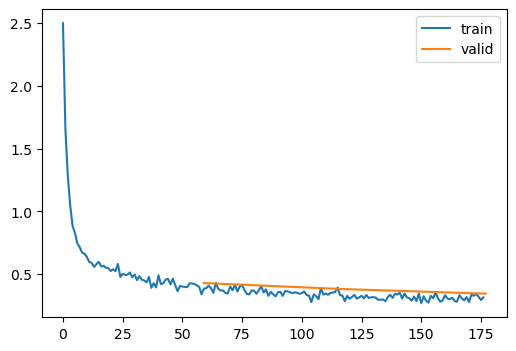

In [39]:
learn.fit(3)

In [43]:
list(filter(lambda x: x[0].isupper() and x[1].islower(),dir(lr_scheduler)))

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'ExponentialLR',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'PolynomialLR',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR']

In [44]:
[x for x in dir(lr_scheduler) if x[0].isupper() and x[1].islower()]

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'ExponentialLR',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'PolynomialLR',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR']

In [62]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, 6e-3,cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [46]:
schedo = lr_scheduler.CosineAnnealingLR(learn.opt,100)

In [65]:
' '.join([x for x in dir(schedo) if x[0] != '_'])

'T_max base_lrs eta_min get_last_lr get_lr last_epoch load_state_dict optimizer print_lr state_dict step verbose'

In [63]:
def plot_sched(opt, Tmax=110):
    schedo = lr_scheduler.CosineAnnealingLR(opt,Tmax) 
    lr_value = [schedo.get_last_lr()]
    for i in range(Tmax):
        schedo.optimizer.step()
        schedo.step()
        lr_value.append(schedo.get_last_lr())
    plt.plot(lr_value)


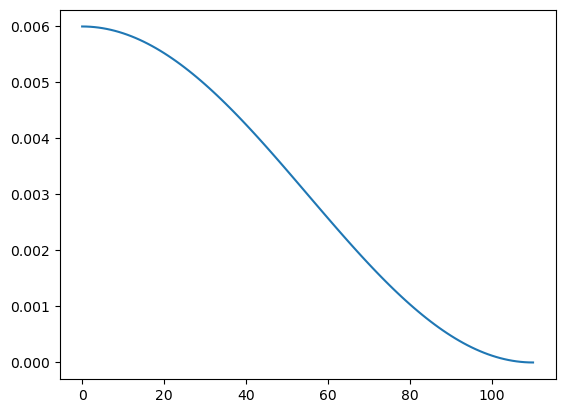

In [64]:
plot_sched(learn.opt,110)

In [66]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0] != '_')


'add_param_group defaults load_state_dict param_groups profile_hook_step register_step_post_hook register_step_pre_hook state state_dict step zero_grad'

In [68]:
list(opt.param_groups[0])

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable',
 'initial_lr']

In [71]:
p = next(iter(learn.model.parameters()))
opt.state[p]

{'momentum_buffer': None}

In [72]:
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched

    def before_fit(self, learn): self.schedo = self.sched(learn.opt)

    def _step(self, learn):
        if learn.training: self.schedo.step()

In [73]:
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

In [79]:
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn)

In [86]:
class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]
    
    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self))

    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [92]:
def _lr(cb): return cb.pg['lr']

In [89]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

accuracy,loss,epoch,train
0.768,0.659,0,train
0.845,0.448,0,eval
0.859,0.386,1,train
0.859,0.406,1,eval
0.885,0.308,2,train
0.882,0.328,2,eval
0.907,0.250,3,train
0.898,0.280,3,eval
0.921,0.213,4,train
0.903,0.268,4,eval


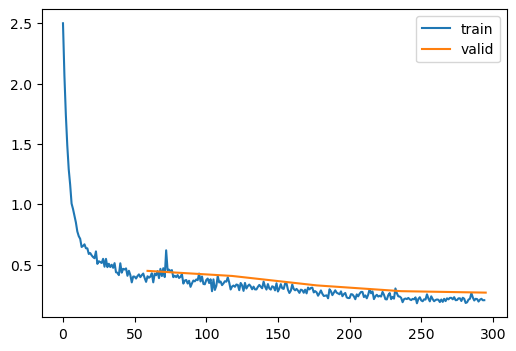

In [90]:

set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

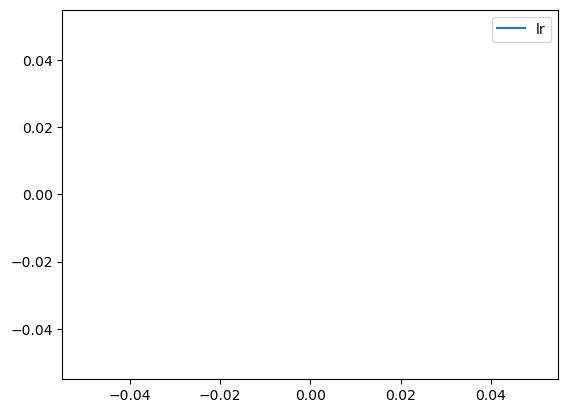

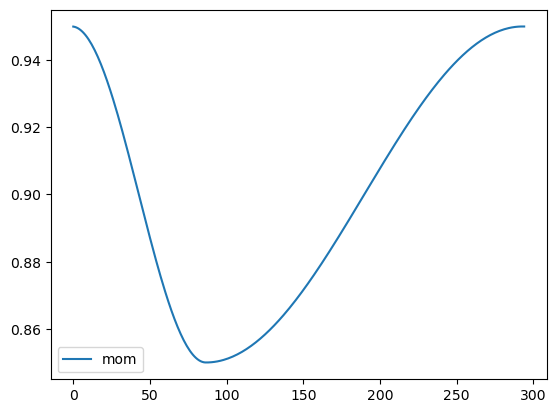

In [91]:
rec.plot()